In [39]:
'''
notebook for playing around with exporting files and georefrencing them in python

eventualy this will be tied together with alot of the scripts from sahi fiftyone into a smooth workflow

'''



# first check the wd
# this should be AIggregation folder. change if needed

import os
os.getcwd()

#os.chdir("..")


'/home/tmueller/github/AIggregation'

In [37]:
# export a test image with its label boxes


import fiftyone as fo

# Import annotated test image into fiftyone dataset type
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = "datasets/test_image/test.yaml"
)


# then export it again
export_dir = "datasets/export_test"
label_field = "ground_truth"  


dataset.export(
        export_dir=export_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field=label_field
    )




 100% |█████████████████████| 1/1 [71.9ms elapsed, 0s remaining, 14.3 samples/s] 
Directory 'datasets/export_test' already exists; export will be merged with existing files
 100% |█████████████████████| 1/1 [35.2ms elapsed, 0s remaining, 28.4 samples/s] 


In [ ]:
# maybe easiest is just reading in the labels file (.csv) from the export and editing it into coordinates

# the name of the file containing the export labels would match the import file names - so ortho something

# multiply csv by image dimensions to get pixel coordinates
# use csv of pixel coordinate points to create a raster 
# use the affine transformation calculated by georefrencng the ortho image to do an identical transformation on the labels raster






/home/tmueller/.local/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


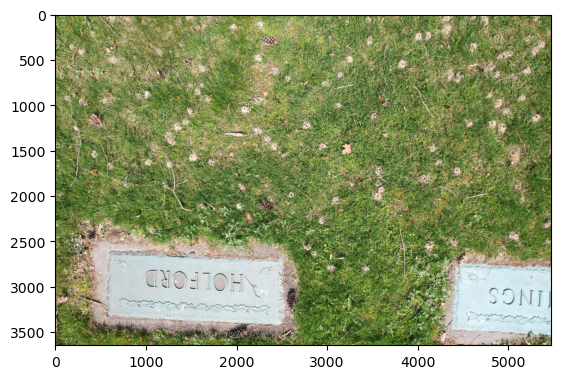

image pixel dimensions are:
(3648, 5472)


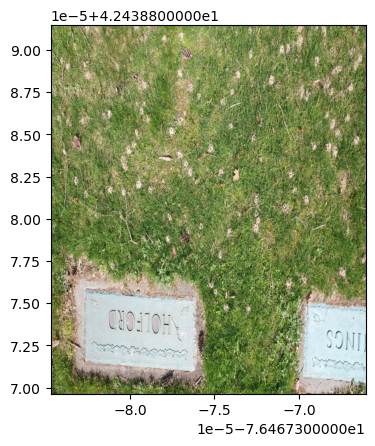

<AxesSubplot:>

In [55]:
# test out rasterio 
# and how to georef image


#import required libraries
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show



# open ungeoreferenced raster
unRefRaster = rasterio.open('datasets/test_image/images/test.JPG')
unRefRaster


# view raster
show(unRefRaster)


# show raster shape 
# this is needed to adjust detection points to pixel coordinates
print("image pixel dimensions are:")
print(unRefRaster.read(1).shape)



# now insert ground control points matching pixels to gps coordinates
# find the image GCP pixels in gimp or somethign similiar and match 


# THIS IS A TEST FOR NOW - not positive on these coordinates
point1 = rasterio.control.GroundControlPoint(col = 604.9, row=-2611.7, x=-76.467396671, y=42.438880045)
point1

point2 = rasterio.control.GroundControlPoint(col = 2496.1, row=-3387.3, x=-76.467399709, y=42.438873231)
point2

point3 = rasterio.control.GroundControlPoint(col = 4463.3, row=-2763.6, x=-76.467396210, y=42.438868351)
point3

# list of selected gcps
points = [point1, point2, point3]
points

# get affine transformation
transformation = rasterio.transform.from_gcps(points)
transformation




#define output raster
outputPath = 'datasets/export_test/geo_test/georefRaster.tif'

#create raster and write bands
with rasterio.open(
    outputPath,
    'w',
    driver='GTiff',
    height=unRefRaster.read(1).shape[0],
    width=unRefRaster.read(1).shape[1],
    count=3,
    dtype=unRefRaster.read(1).dtype,
    crs=rasterio.crs.CRS.from_epsg(4326),
    transform=transformation,
) as dst:
    dst.write(unRefRaster.read(1), 1)
    dst.write(unRefRaster.read(2), 2)
    dst.write(unRefRaster.read(3), 3)

#show georeferenced raster
geoRaster = rasterio.open(outputPath)
show(geoRaster)



